In [ ]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from urllib import request
from scipy.interpolate import interp1d
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import speclite.filters as sp
from speclite import filters
from scipy.ndimage import sum_labels, mean
from scipy.stats import linregress, spearmanr


from astropy.io import fits
from astropy import units as u
from astropy import constants as c
from astropy.wcs import WCS
from astropy.wcs.utils import proj_plane_pixel_scales

from ppxf.ppxf import ppxf, rebin
import ppxf.ppxf_util as util
from ppxf import sps_util as lib

import os
import sys
import glob

In [2]:
kin_path = Path('NGC4298_KIN_maps.fits')
print(f"Loading kinematic map from {kin_path}")
with fits.open(kin_path) as hdul:
    kin_info = hdul.info()
    
    # Read data from all extensions except PRIMARY
    extension_names = [hdul[i].name for i in range(1, len(hdul))]
    print(f"Available extensions: {extension_names}")
    
    # Read each extension's data before closing the file
    for ext_name in extension_names:
        if ext_name and ext_name != "PRIMARY":
            globals()[ext_name] = hdul[ext_name].data
            print(f"Loaded {ext_name}: shape {globals()[ext_name].shape}")

print("All data loaded successfully!")


Loading kinematic map from NGC4298_KIN_maps.fits
Filename: NGC4298_KIN_maps.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  V             1 ImageHDU        26   (1042, 995)   float64   
  2  SIGMA         1 ImageHDU        26   (1042, 995)   float64   
  3  H3            1 ImageHDU        26   (1042, 995)   float64   
  4  H4            1 ImageHDU        26   (1042, 995)   float64   
  5  FORM_ERR_V    1 ImageHDU        26   (1042, 995)   float64   
  6  FORM_ERR_SIGMA    1 ImageHDU        26   (1042, 995)   float64   
  7  FORM_ERR_H3    1 ImageHDU        26   (1042, 995)   float64   
  8  FORM_ERR_H4    1 ImageHDU        26   (1042, 995)   float64   
  9  SNR_POSTFIT    1 ImageHDU        26   (1042, 995)   float64   
Available extensions: ['V', 'SIGMA', 'H3', 'H4', 'FORM_ERR_V', 'FORM_ERR_SIGMA', 'FORM_ERR_H3', 'FORM_ERR_H4', 'SNR_POSTFIT']
Loaded V: shape (995, 1042)
Loaded SIGMA: shape (995, 1042)
Loaded H3:

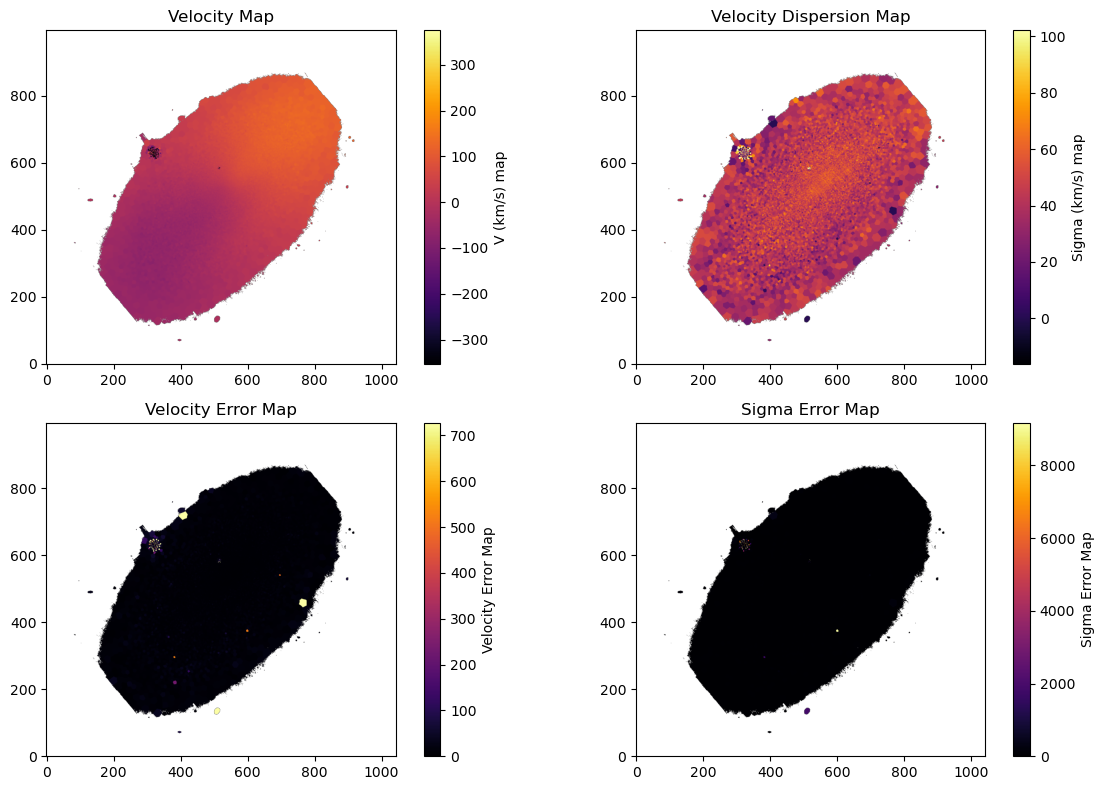

In [3]:
# Plot the V, Sigma, FORM_ERR_V and FORM_ERR_SIGMA maps
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(V, origin='lower', cmap='inferno', vmin=np.nanmedian(V)-5*np.nanstd(V), vmax=np.nanmedian(V)+5*np.nanstd(V))
plt.colorbar(label='V (km/s) map')
plt.title('Velocity Map')
plt.subplot(2, 2, 2)
plt.imshow(SIGMA, origin='lower', cmap='inferno', vmin=np.nanmedian(SIGMA)-5*np.nanstd(SIGMA), vmax=np.nanmedian(SIGMA)+5*np.nanstd(SIGMA))
plt.colorbar(label='Sigma (km/s) map')
plt.title('Velocity Dispersion Map')
plt.subplot(2, 2, 3)
plt.imshow(FORM_ERR_V, origin='lower', cmap='inferno', vmin=0, vmax=5*np.nanstd(FORM_ERR_V))
plt.colorbar(label='Velocity Error Map')
plt.title('Velocity Error Map')
plt.subplot(2, 2, 4)
plt.imshow(FORM_ERR_SIGMA, origin='lower', cmap='inferno', vmin=0, vmax=5*np.nanstd(FORM_ERR_SIGMA))
plt.colorbar(label='Sigma Error Map')
plt.title('Sigma Error Map')
plt.tight_layout()
plt.show()

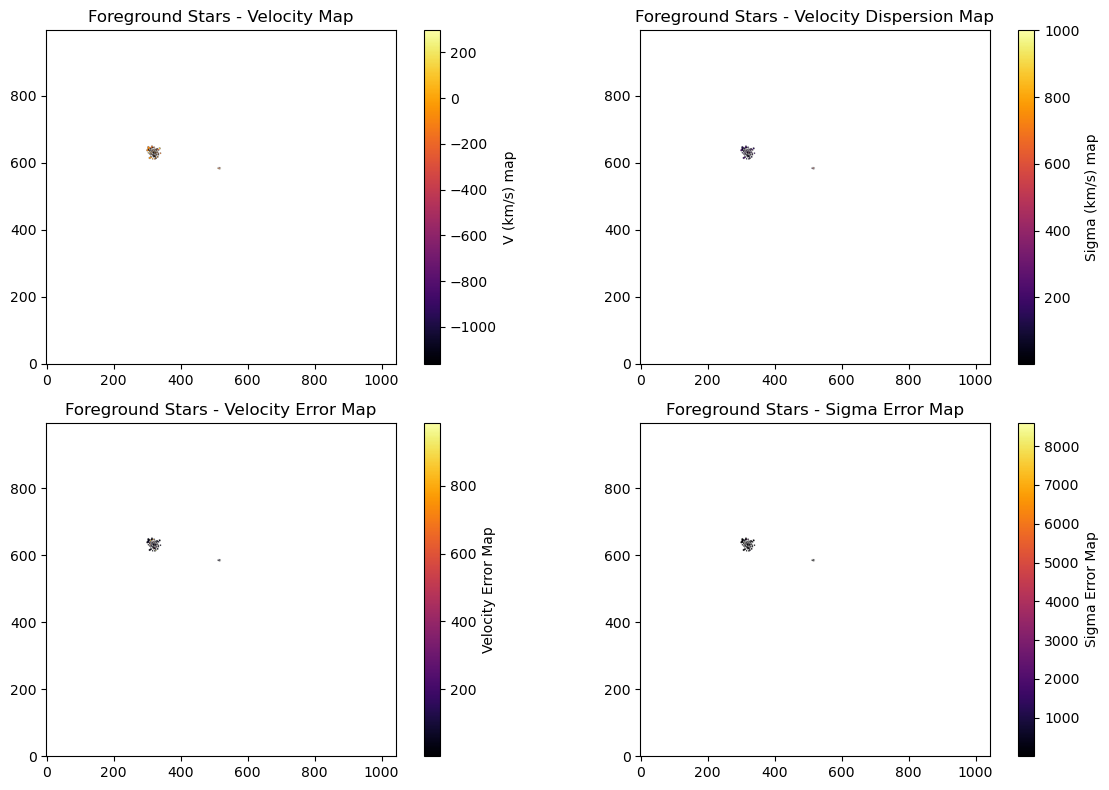

In [4]:
# Foreground star selection: outside median ± 5*std in V or Sigma, or >5*std in errors of V or Sigma, while preserving NaNs
foreground_stars = np.where(
    (np.abs(V - np.nanmedian(V)) >= 5 * np.nanstd(V)) 
    | (np.abs(SIGMA - np.nanmedian(SIGMA)) >= 5 * np.nanstd(SIGMA)) 
    # | (FORM_ERR_V >= 5 * np.nanstd(FORM_ERR_V)) 
    # | (FORM_ERR_SIGMA >= 5 * np.nanstd(FORM_ERR_SIGMA))
)

# Create a mask for foreground stars
foreground_mask = np.zeros_like(V, dtype=bool)
foreground_mask[foreground_stars] = True

# Plot the V, Sigma, FORM_ERR_V and FORM_ERR_SIGMA maps for foreground stars
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.imshow(np.where(foreground_mask, V, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='V (km/s) map')
plt.title('Foreground Stars - Velocity Map')
plt.subplot(2, 2, 2)
plt.imshow(np.where(foreground_mask, SIGMA, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Sigma (km/s) map')
plt.title('Foreground Stars - Velocity Dispersion Map')
plt.subplot(2, 2, 3)
plt.imshow(np.where(foreground_mask, FORM_ERR_V, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Velocity Error Map')
plt.title('Foreground Stars - Velocity Error Map')
plt.subplot(2, 2, 4)
plt.imshow(np.where(foreground_mask, FORM_ERR_SIGMA, np.nan), origin='lower', cmap='inferno')
plt.colorbar(label='Sigma Error Map')
plt.title('Foreground Stars - Sigma Error Map')
plt.tight_layout()
plt.show()

In [5]:
# # Iterative circle fitting to exclude points that are too far
# current_mask = foreground_mask.copy()
# iteration = 0
# max_iterations = 10
# max_radius = 50  # Maximum radius in pixels to consider for the circle

# while iteration < max_iterations:
#     # Find all non-NaN points in the current mask
#     y_coords, x_coords = np.where(current_mask)
    
#     if len(x_coords) == 0:
#         print("No points remaining to fit circle")
#         break
    
#     # Calculate center as the mean of all points
#     center_x = np.mean(x_coords)
#     center_y = np.mean(y_coords)
    
#     # Calculate distances from center to all points
#     distances = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    
#     # Find points outside the max_radius circle
#     points_outside = distances > max_radius
    
#     if not np.any(points_outside):
#         print(f"All points within radius {max_radius} after {iteration} iterations")
#         break
    
#     # Check distances for points outside the circle
#     outside_distances = distances[points_outside]
#     far_points = outside_distances > 2 * max_radius
    
#     if not np.any(far_points):
#         print(f"No points beyond 2*radius ({2*max_radius}) after {iteration} iterations")
#         break
    
#     # Remove points that are > 2*max_radius from center
#     points_to_remove = np.where(points_outside)[0][far_points]
    
#     # Create new mask excluding far points
#     for idx in points_to_remove:
#         current_mask[y_coords[idx], x_coords[idx]] = False
    
#     points_removed = len(points_to_remove)
#     print(f"Iteration {iteration + 1}: Removed {points_removed} points beyond 2*radius")
    
#     iteration += 1

# # Final results - find minimum radius to include all remaining points
# y_coords, x_coords = np.where(current_mask)
# if len(x_coords) > 0:
#     final_center_x = np.mean(x_coords)
#     final_center_y = np.mean(y_coords)
#     final_distances = np.sqrt((x_coords - final_center_x)**2 + (y_coords - final_center_y)**2)
    
#     # Find the minimum radius that includes all remaining points
#     min_radius_all = np.max(final_distances)
#     points_within_max_radius = np.sum(final_distances <= max_radius)
    
#     # Create the final plot
#     plt.figure(figsize=(10, 8))
#     plt.imshow(np.where(current_mask, 1, np.nan), origin='lower', cmap='Grays', vmin=0, vmax=1)
    
#     # Add circle with minimum radius that includes all points
#     circle_min = plt.Circle((final_center_x, final_center_y), min_radius_all, fill=False, color='green', linewidth=2)
#     plt.gca().add_patch(circle_min)
    
#     # Add circle with original max radius for reference
#     circle_max = plt.Circle((final_center_x, final_center_y), max_radius, fill=False, color='red', linewidth=2, linestyle='--')
#     plt.gca().add_patch(circle_max)
    
#     # plt.xticks([])
#     # plt.yticks([])
#     plt.title(f'Final Foreground Stars with Minimum Enclosing Circle\nCenter: ({final_center_x:.1f}, {final_center_y:.1f})')
#     plt.legend(['Min radius (all points)', 'Original max radius'], loc='upper right')
#     plt.show()
    
#     print(f"\nFinal circle center: ({final_center_x:.2f}, {final_center_y:.2f})")
#     print(f"Minimum radius to include all points: {min_radius_all:.2f}")
#     print(f"Original max radius: {max_radius}")
#     print(f"Points within original max radius: {points_within_max_radius} out of {len(x_coords)} total points")
#     print(f"Total points included: {len(x_coords)}")
#     print(f"Total iterations: {iteration}")
# else:
#     print("No foreground stars remaining after filtering")

In [6]:
# # Create a new mask for all spaxels inside or partially inside the circle
# # Get the shape of the original mask
# mask_shape = foreground_mask.shape

# # Create coordinate grids
# y_grid, x_grid = np.meshgrid(np.arange(mask_shape[1]), np.arange(mask_shape[0]), indexing='ij')
# y_grid = y_grid.T
# x_grid = x_grid.T

# # Calculate distances from each pixel to the circle center
# distances_from_center = np.sqrt((x_grid - final_center_y)**2 + (y_grid - final_center_x)**2)

# # Update foreground_mask to include all pixels within the minimum enclosing circle
# # Using the minimum radius that includes all points
# foreground_mask = distances_from_center <= min_radius_all

# foreground_mask = np.where(np.isfinite(V),foreground_mask, np.nan)

# # Verify the update
# print(f"Updated foreground_mask shape: {foreground_mask.shape}")
# print(f"Number of pixels in updated mask: {np.sum(foreground_mask)}")
# print(f"Circle radius used: {min_radius_all:.2f}")

# # Plot the updated mask to visualize
# plt.figure(figsize=(10, 8)) 
# plt.imshow(foreground_mask, origin='lower', cmap='Grays')
# plt.title('Updated Foreground Mask - All Spaxels Inside Circle')
# # plt.xticks([])
# # plt.yticks([])
# plt.show()


In [ ]:
plt.figure(figsize=(20, 20))
plt.imshow(foreground_mask, origin='lower', cmap='inferno')
plt.xticks([])
plt.yticks([])
plt.show()

Number of connected components found: 15
Component sizes: [ 30.   2.   2.  13. 612.  53.  19.   2.  21.   1.  14.   1.   2.   5.
   2.]


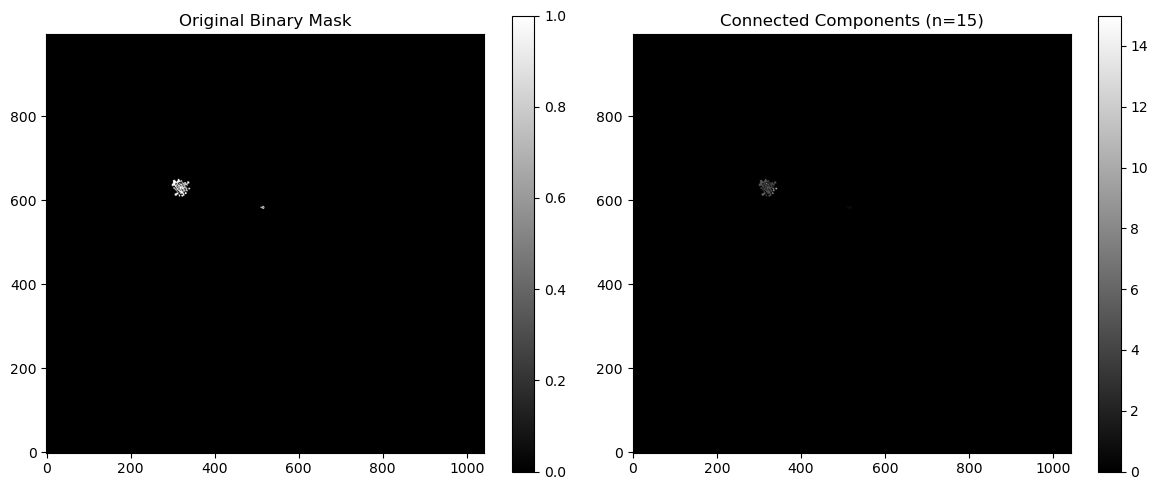

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], shape=(995, 1042))

In [29]:
from scipy import ndimage

# make foreground_mask True for 1, False for 0, the output should be binarized
foreground_mask = foreground_mask.astype(int)
# Connected components analysis

# Label connected components
labeled_array, num_features = ndimage.label(foreground_mask)

print(f"Number of connected components found: {num_features}")

# Get component sizes
component_sizes = ndimage.sum(foreground_mask, labeled_array, range(1, num_features + 1))
print(f"Component sizes: {component_sizes}")

# Visualize the labeled components
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(foreground_mask, origin='lower', cmap='gray')
plt.title('Original Binary Mask')
plt.colorbar()

plt.subplot(1, 2, 2)
plt.imshow(labeled_array, origin='lower', cmap='gray')
plt.title(f'Connected Components (n={num_features})')
plt.colorbar()

plt.tight_layout()
plt.show()

foreground_mask

Number of connected components after closing: 2
Component sizes after closing: [  48. 1274.]


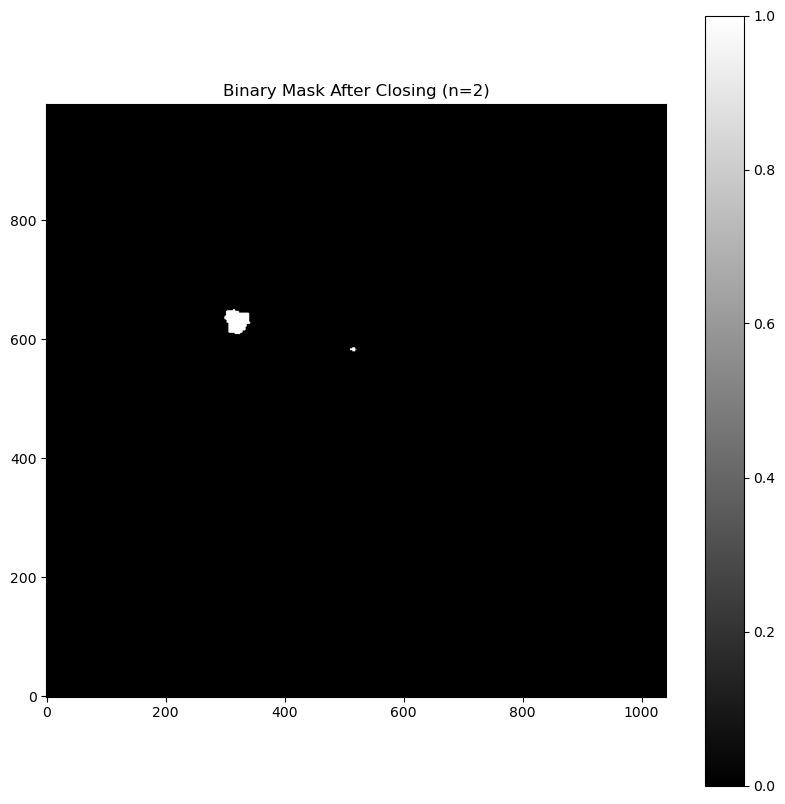

In [31]:
# Run closing operation to fill small holes
foreground_mask_closed = ndimage.binary_closing(foreground_mask, structure=np.ones((3, 3)), iterations=10)
# Label connected components again after closing
labeled_array_closed, num_features_closed = ndimage.label(foreground_mask_closed)
print(f"Number of connected components after closing: {num_features_closed}")
# Get component sizes after closing
component_sizes_closed = ndimage.sum(foreground_mask_closed, labeled_array_closed, range(1, num_features_closed + 1))
print(f"Component sizes after closing: {component_sizes_closed}")
# Visualize the labeled components after closing
plt.figure(figsize=(10, 10))
plt.imshow(foreground_mask_closed, origin='lower', cmap='gray')
plt.title(f'Binary Mask After Closing (n={num_features_closed})')
plt.colorbar()
plt.show()


Fitted circles for each component:
Component 1: Center = (514.98, 582.94), Radius = 5.09
Component 2: Center = (320.00, 629.96), Radius = 24.79


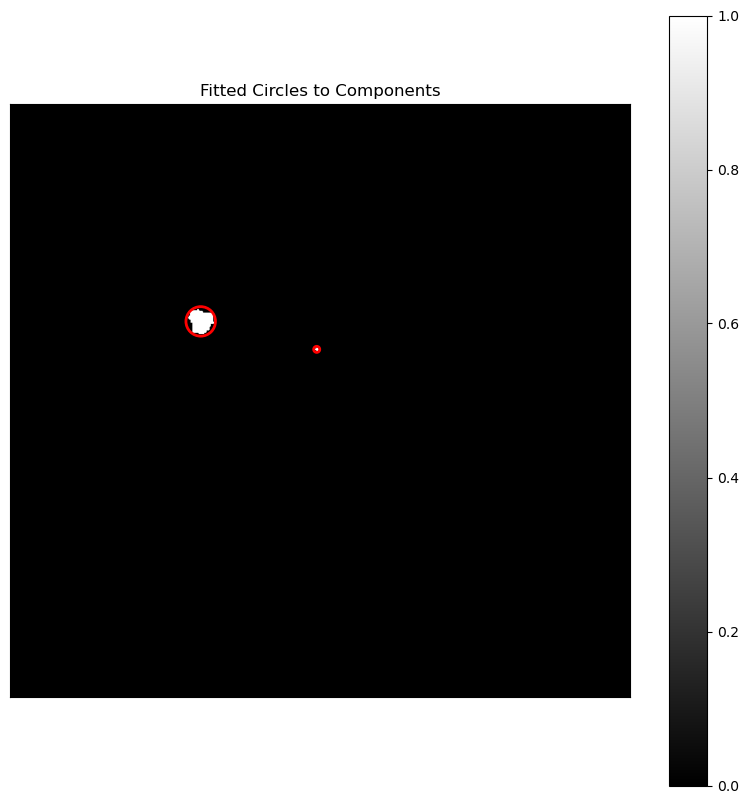

In [32]:
# Now fit a smallest circle to each component but also enclosing each component into the circle
def fit_circle_to_component(component_mask):
    """Fit a circle to the given binary component mask."""
    y_coords, x_coords = np.where(component_mask)
    
    if len(x_coords) == 0:
        return None, None, None  # No points to fit
    
    # Calculate center as the mean of all points
    center_x = np.mean(x_coords)
    center_y = np.mean(y_coords)
    
    # Calculate distances from center to all points
    distances = np.sqrt((x_coords - center_x)**2 + (y_coords - center_y)**2)
    
    # Find the maximum distance (radius) to include all points
    radius = np.max(distances)
    
    return center_x, center_y, radius
# Fit circles to each component
component_centers = []
component_radii = []
for i in range(1, num_features_closed + 1):
    component_mask = (labeled_array_closed == i)
    center_x, center_y, radius = fit_circle_to_component(component_mask)
    
    if center_x is not None:
        component_centers.append((center_x, center_y))
        component_radii.append(radius)
# Print the fitted circles
print("Fitted circles for each component:")
for i, (center, radius) in enumerate(zip(component_centers, component_radii)):
    print(f"Component {i + 1}: Center = ({center[0]:.2f}, {center[1]:.2f}), Radius = {radius:.2f}")
# Plot the original mask with fitted circles
plt.figure(figsize=(10, 10))
plt.imshow(foreground_mask_closed, origin='lower', cmap='gray')
for (center_x, center_y), radius in zip(component_centers, component_radii):
    circle = plt.Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    plt.gca().add_patch(circle)
plt.title('Fitted Circles to Components')
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.show()

Updated foreground_mask_final shape: (995, 1042)
Number of pixels in updated mask: 8045


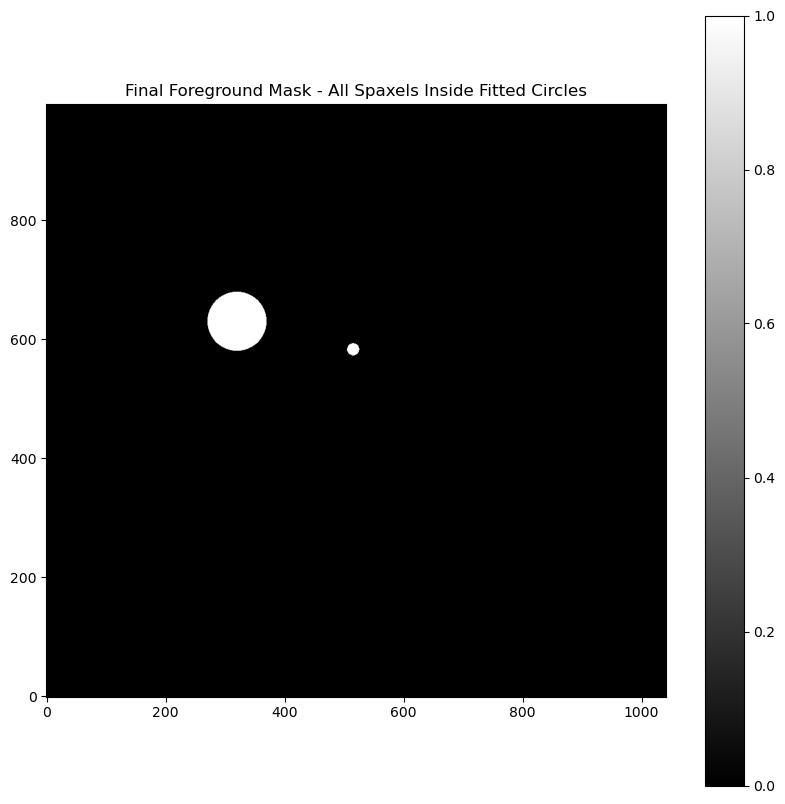

In [40]:
# now we want to update the foreground_mask to include all pixels inside the fitted circles, but 2 times the radius
foreground_mask_final = np.zeros_like(foreground_mask_closed, dtype=bool)
# Create coordinate grids
y_grid, x_grid = np.meshgrid(np.arange(foreground_mask_closed.shape[0]), np.arange(foreground_mask_closed.shape[1]), indexing='ij')
# Update foreground_mask_final to include all pixels inside the fitted circles
for (center_x, center_y), radius in zip(component_centers, component_radii):
    distances_from_center = np.sqrt((x_grid - center_x)**2 + (y_grid - center_y)**2)
    foreground_mask_final |= (distances_from_center <= 2 * radius)
# Verify the update
print(f"Updated foreground_mask_final shape: {foreground_mask_final.shape}")
print(f"Number of pixels in updated mask: {np.sum(foreground_mask_final)}")
# Plot the updated mask to visualize
plt.figure(figsize=(10, 10))
plt.imshow(foreground_mask_final, origin='lower', cmap='gray')
plt.title('Final Foreground Mask - All Spaxels Inside Fitted Circles')
plt.colorbar()
# plt.xticks([])
# plt.yticks([])
plt.show()

In [34]:
V

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]],
      shape=(995, 1042), dtype='>f8')

In [36]:
foreground_mask_final

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]], shape=(995, 1042))

In [38]:
foreground_mask_final = np.where(np.isfinite(V),foreground_mask_final, np.nan)

In [39]:
foreground_mask_final

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], shape=(995, 1042))